## Imports

In [24]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import sys
import pickle
import wandb

import torch.optim as optim


from utils.miscellaneous import read_config
from utils.miscellaneous import create_folder_structure_MLPvsGNN
from utils.miscellaneous import initalize_random_generators
from utils.wandb_logger import save_response_graphs_in_ML_tracker
from utils.normalization import *
from utils.load import *

from training.train import training
from training.test import testing
from training.models import * 

from utils.visualization import plot_R2, plot_loss
from matplotlib import pyplot as plt

### Parse configuration file + initializations


In [25]:
# read config files
cfg = read_config("config_unrolling.yaml")
# create folder for result
exp_name = cfg['exp_name']
data_folder = cfg['data_folder']
results_folder = create_folder_structure_MLPvsGNN(cfg, parent_folder='./experiments')

all_wdn_names = cfg['network']
initalize_random_generators(cfg, count=0)

# initialize pytorch device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.set_num_threads(12)

Creating folder: ./experiments/unrolling_WDN0074
cpu


In [26]:
# TO DO: at the moment I am not using the parsed values for batch size and num_epochs ;
# I am not using alpha as well because the loss has no "smoothness" penalty (yet)
batch_size = cfg['trainParams']['batch_size']
num_epochs = cfg['trainParams']['num_epochs']
res_columns = ['train_loss', 'valid_loss', 'test_loss', 'max_train_loss', 'max_valid_loss', 'max_test_loss',
               'min_train_loss', 'min_valid_loss', 'min_test_loss', 'r2_train', 'r2_valid',
               'r2_test', 'total_params', 'total_time', 'test_time']

# Functions

## Models
I will be Creating different models as follows:

* A simple LSTM
* An unrolled version of Heads and Flows, without static variables
* An unrolled version with Heads, Flows and static variables


## Running experiments

In [27]:
for ix_wdn, wdn in enumerate(all_wdn_names):
    print(f'\nWorking with {wdn}, network {ix_wdn + 1} of {len(all_wdn_names)}')

    # retrieve wntr data
    tra_database, val_database, tst_database = load_raw_dataset(wdn, data_folder)
    # reduce training data
    # tra_database = tra_database[:int(len(tra_database)*cfg['tra_prc'])]
    if cfg['tra_num'] < len(tra_database):
        tra_database = tra_database[:cfg['tra_num']]


    # get GRAPH datasets     
    # later on we should change this and use normal scalers from scikit (something is off here)
    tra_dataset, A12_bar = create_dataset(tra_database)
    # number of nodes
    junctions = (tra_database[0].node_type == JUNCTION_TYPE).numpy().sum()
    tanks = (tra_database[0].node_type == TANK_TYPE).numpy().sum()
    output_nodes = len(tra_dataset[0].y[0]) # remove reservoirs
    gn = GraphNormalizer(junctions + tanks, output=['pressure', 'pump_flow'])
    gn = gn.fit(tra_dataset)
    # The normalization messed with the 1H_type since we want unique IDs
    tra_dataset, _ = create_dataset(tra_database, normalizer=gn)
    val_dataset, _ = create_dataset(val_database, normalizer=gn)
    tst_dataset, _ = create_dataset(tst_database, normalizer=gn)
    node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
    
    # dataloader
    # transform dataset for MLP
    # We begin with the MLP versions, when I want to add GNNs, check Riccardo's code
    A10, A12 = create_incidence_matrices(tra_dataset, A12_bar)
    tra_dataset_MLP, num_inputs, indices = create_dataset_MLP_from_graphs(tra_dataset)
    val_dataset_MLP = create_dataset_MLP_from_graphs(val_dataset)[0]
    tst_dataset_MLP = create_dataset_MLP_from_graphs(tst_dataset)[0]
    tra_loader = torch.utils.data.DataLoader(tra_dataset_MLP,
                                             batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    tst_loader = torch.utils.data.DataLoader(tst_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    # loop through different algorithms
    for algorithm in cfg['algorithms']:
        # Importing of configuration parameters
        hyperParams = cfg['hyperParams'][algorithm]
        all_combinations = ParameterGrid(hyperParams)

        # create results dataframe
        results_df = pd.DataFrame(list(all_combinations))
        results_df = pd.concat([results_df,
                                pd.DataFrame(index=np.arange(len(all_combinations)),
                                             columns=list(res_columns))], axis=1)

        for i, combination in enumerate(all_combinations):
            # wandb.init(project="unrolling-epanet", entity="mertz")
            print(f'{algorithm}: training combination {i + 1} of {len(all_combinations)}\n')
            
            combination['indices'] = indices
            combination['junctions'] = junctions
            combination['num_outputs'] = output_nodes

            # model creation
            model = getattr(sys.modules[__name__], algorithm)(**combination).float().to(device)

            # get combination dictionary to determine how are indices made
            total_parameters = sum(p.numel() for p in model.parameters())
            print("Total number of parameters is", total_parameters)

            # model optimizer
            optimizer = optim.Adam(params=model.parameters(), betas=(0.9, 0.999), **cfg['adamParams'])

            # training
            patience = cfg['earlyStopping']['patience']
            lr_rate = cfg['earlyStopping']['divisor']
            lr_epoch = cfg['earlyStopping']['epoch_frequency']
            train_config = {"Patience": patience, "Learning Rate Divisor": lr_rate, "LR Epoch Division": lr_epoch}
            model, tra_losses, val_losses, elapsed_time = training(model, optimizer, tra_loader, val_loader,
                                                                   patience=patience, report_freq=0,
                                                                   n_epochs=num_epochs,
                                                                   alpha=0, lr_rate=lr_rate, lr_epoch=lr_epoch,
                                                                   normalization=None, path="experiments")
            
            loss_plot = plot_loss(tra_losses, val_losses, f'{results_folder}/{wdn}/{algorithm}/loss/{i}')
            R2_plot = plot_R2(model, val_loader, f'{results_folder}/{wdn}/{algorithm}/R2/{i}', normalization=gn)[1]
            # store training history and model
            pd.DataFrame(data=np.array([tra_losses, val_losses]).T).to_csv(
                f'{results_folder}/{wdn}/{algorithm}/hist/{i}.csv')
            torch.save(model, f'{results_folder}/{wdn}/{algorithm}/models/{i}.csv')

            # compute and store predictions, compute r2 scores
            losses = {}
            max_losses = {}
            min_losses = {}
            r2_scores = {}
            for split, loader in zip(['training', 'validation', 'testing'], [tra_loader, val_loader, tst_loader]):
                losses[split], max_losses[split], min_losses[split], pred, real, test_time = testing(model, loader, normalization=gn)
                r2_scores[split] = r2_score(real, pred)
                if i == 0:
                    pd.DataFrame(data=real.reshape(-1, output_nodes)).to_csv(
                        f'{results_folder}/{wdn}/{algorithm}/pred/{split}/real.csv')  # save real obs
                pd.DataFrame(data=pred.reshape(-1, output_nodes)).to_csv(
                    f'{results_folder}/{wdn}/{algorithm}/pred/{split}/{i}.csv')

            # log_wandb_data(combination, wdn, algorithm, len(tra_database), len(val_database), len(tst_database), cfg, train_config, loss_plot, R2_plot)
            # store results
            results_df.loc[i, res_columns] = (losses['training'], losses['validation'], losses['testing'],
                                              max_losses['training'], max_losses['validation'], max_losses['testing'],
                                              min_losses['training'], min_losses['validation'], min_losses['testing'],
                                              r2_scores['training'], r2_scores['validation'], r2_scores['testing'],
                                              total_parameters, elapsed_time, test_time)
            
        # Calculate dummy model    
        # wandb.finish()
        # save graph normalizer
        # with open(f'{results_folder}/{wdn}/{algorithm}/gn.pickle', 'wb') as handle:
        #     pickle.dump(gn, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # 
        with open(f'{results_folder}/{wdn}/{algorithm}/model.pickle', 'wb') as handle:
            torch.save(model, handle)
        results_df.to_csv(f'{results_folder}/{wdn}/{algorithm}/results_{algorithm}.csv')
        
        print('Folder where model was saved is', results_folder)



Working with EPANET Net 3, network 1 of 1
UnrollingModelQ: training combination 1 of 1

Total number of parameters is 232034


  5%|▌         | 100/2000 [01:15<24:44,  1.28it/s]

Learning rate is divided by 2 to: 0.0005


 10%|█         | 200/2000 [02:32<31:58,  1.07s/it]

Learning rate is divided by 2 to: 0.00025


 15%|█▌        | 300/2000 [04:02<29:14,  1.03s/it]

Learning rate is divided by 2 to: 0.000125


 20%|██        | 400/2000 [05:29<22:17,  1.20it/s]

Learning rate is divided by 2 to: 6.25e-05


 25%|██▌       | 500/2000 [07:00<20:54,  1.20it/s]

Learning rate is divided by 2 to: 3.125e-05


 30%|███       | 600/2000 [08:29<19:12,  1.21it/s]

Learning rate is divided by 2 to: 1.5625e-05


 35%|███▌      | 700/2000 [09:57<19:30,  1.11it/s]

Learning rate is divided by 2 to: 7.8125e-06


 40%|████      | 800/2000 [11:21<15:56,  1.25it/s]

Learning rate is divided by 2 to: 3.90625e-06


 45%|████▌     | 900/2000 [12:50<15:22,  1.19it/s]

Learning rate is divided by 2 to: 1.953125e-06


 50%|█████     | 1000/2000 [14:23<15:21,  1.09it/s]

Learning rate is divided by 2 to: 9.765625e-07


 55%|█████▌    | 1100/2000 [16:01<12:42,  1.18it/s]

Learning rate is divided by 2 to: 4.8828125e-07


 60%|██████    | 1200/2000 [17:33<11:51,  1.12it/s]

Learning rate is divided by 2 to: 2.44140625e-07


 63%|██████▎   | 1253/2000 [18:21<10:56,  1.14it/s]

Early Stopping


Folder where model was saved is ./experiments/unrolling_WDN0074


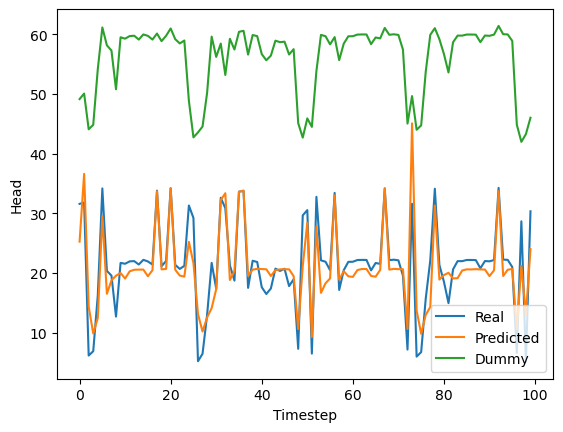

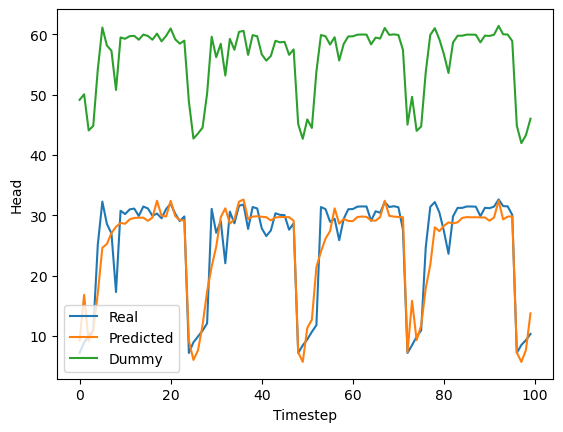

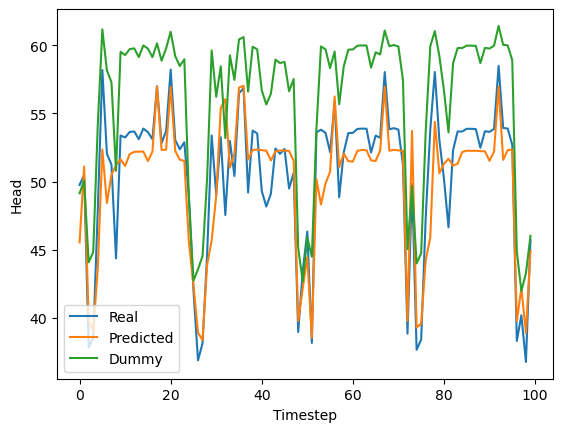

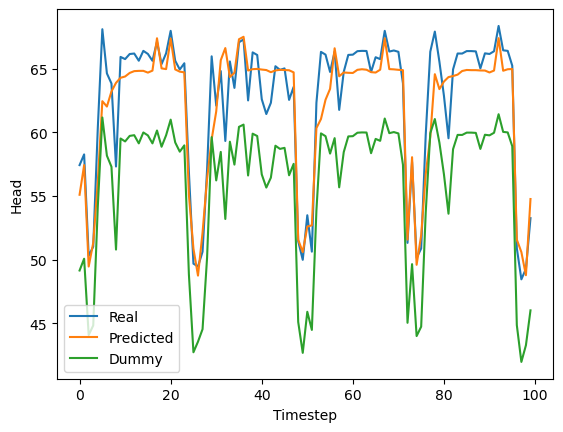

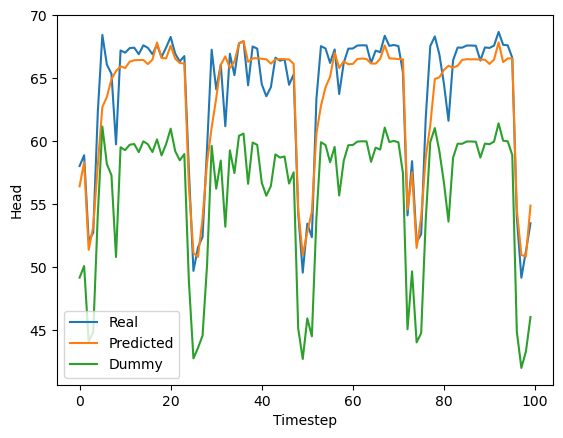

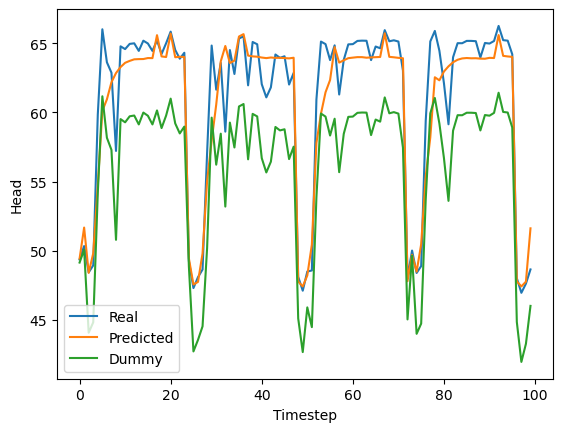

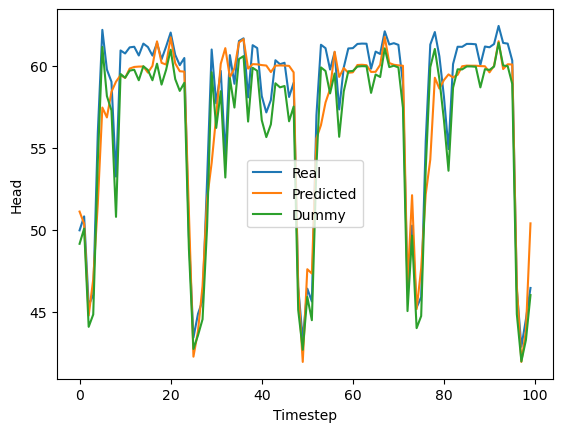

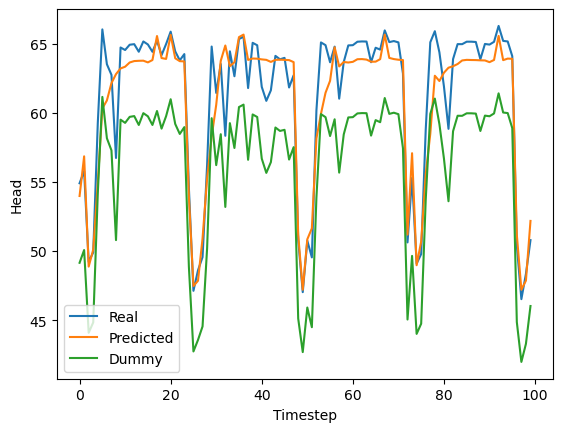

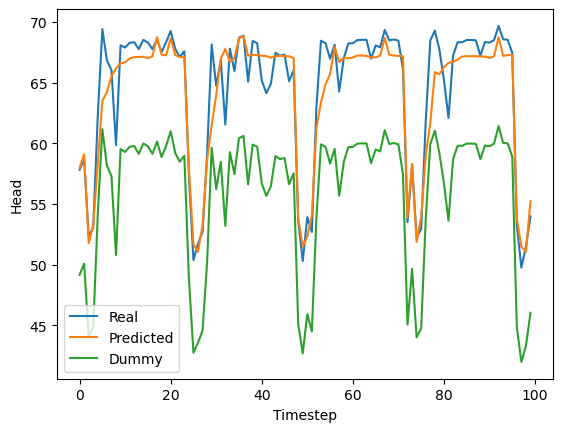

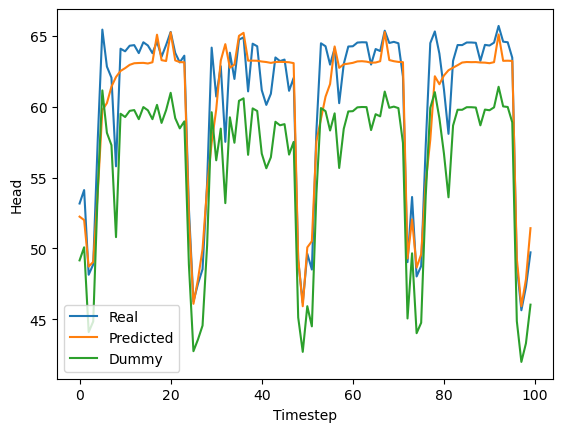

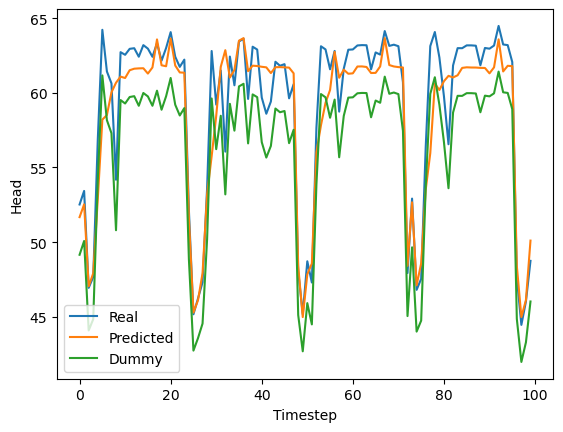

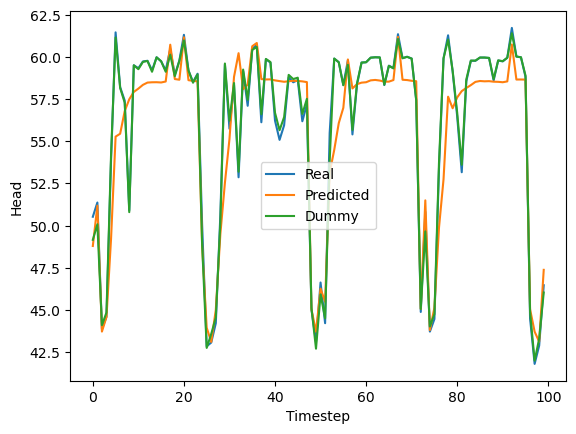

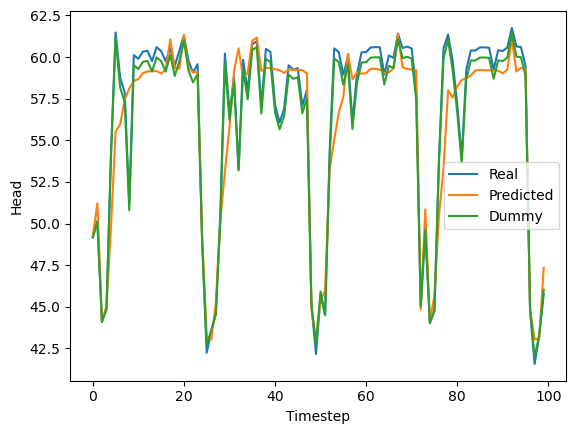

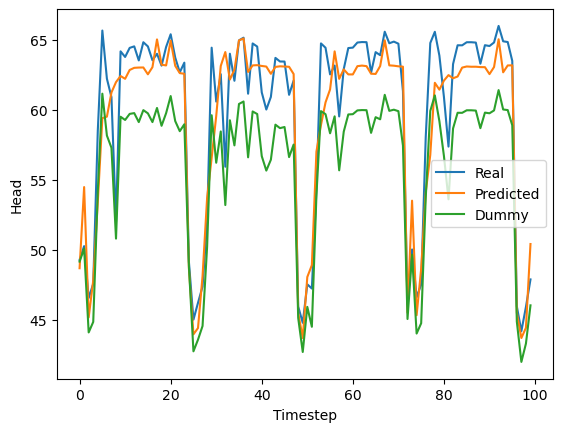

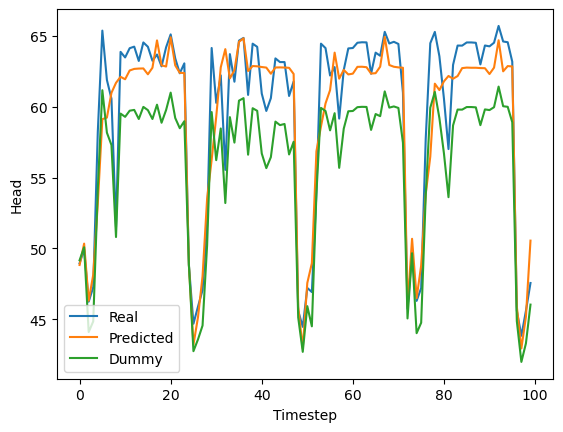

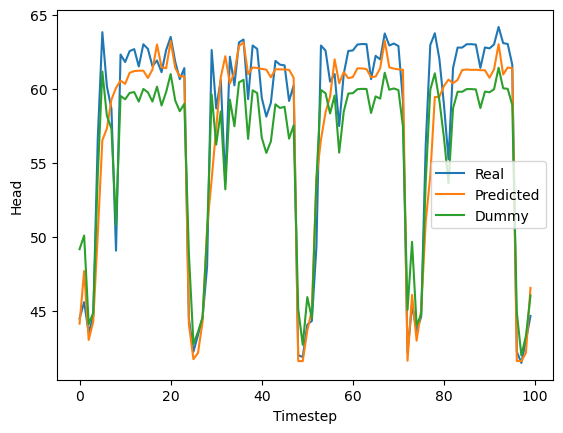

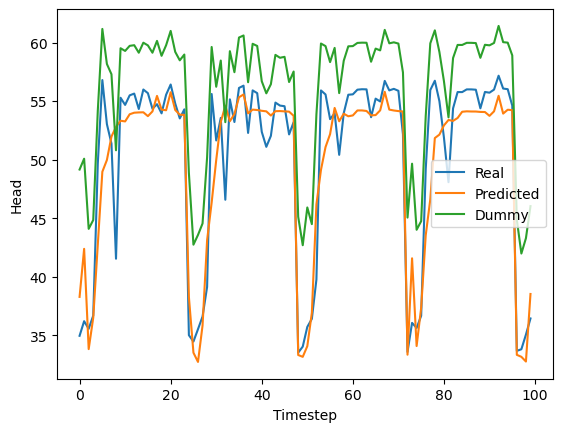

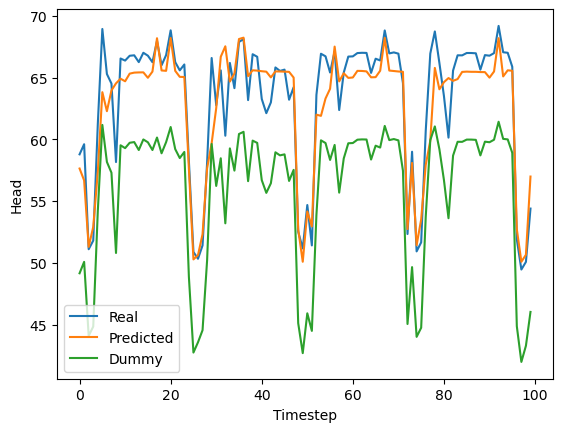

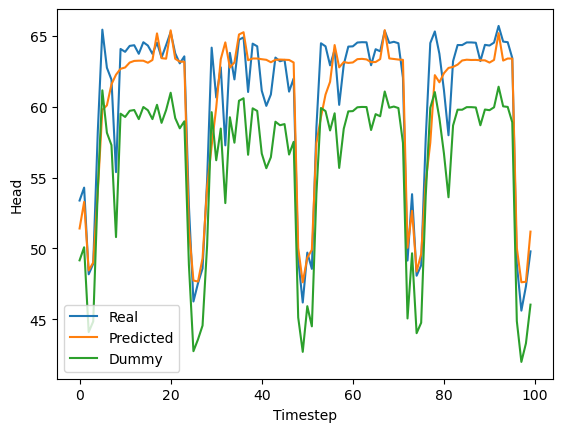

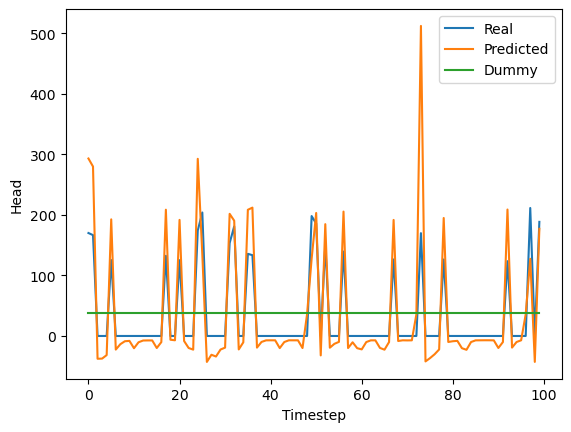

IndexError: index 100 is out of bounds for dimension 1 with size 97

In [28]:
from utils.Dashboard import Dashboard
_, _, _, pred, real, timed = testing(model, tst_loader, normalization=gn)

pred = gn.denormalize_multiple(pred, output_nodes)
real = gn.denormalize_multiple(real, output_nodes)

dummy = Dummy(junctions + tanks).evaluate(real)
# Array below is created to ensure proper indexing of the nodes when displaying
type_array = (tst_database[0].node_type == 0) | (tst_database[0].node_type == 2)
d = Dashboard(pd.DataFrame(real[0:24, :]), pd.DataFrame(pred[0:24, :]),
              to_networkx(tst_dataset[0], node_attrs=['pos', 'ID']), type_array)
# f = d.display_results()

for i in range(0, len(real[:]), 5):
    plt.plot(real[0:100, i], label="Real")
    plt.plot(pred[0:100, i], label="Predicted")
    plt.plot(dummy[0:100, i], label="Dummy")
    plt.ylabel('Head')
    plt.xlabel('Timestep')
    
    plt.legend()
    # names = {0: 'Next to Reservoir', 1: 'Random Node', 6: 'Next to Tank', 26: 'Random Node', 36: 'Tank', 37: 'Pump'}
    # plt.title(names[i])
    # save_response_graphs_in_ML_tracker(real, pred, names[i], i)
    plt.show()
    plt.close()

# plt.plot(real[0:100, 37], label="Real")
# plt.plot(pred[0:100, 37], label="Predicted")
# plt.plot(dummy[0:100, 37], label="Dummy")
# plt.ylabel('LPS')
# plt.xlabel('Timestep')
# 
# plt.legend()
# plt.title(names[37])
# plt.show()
# plt.close()
# save_response_graphs_in_ML_tracker(real, pred, names[i], i)
# Create a table

# Add Plotly figure as HTML file into Table
table = wandb.Table(columns = ["Figure" + str(i)])
# with open('./my_HTML_' + str(i) + '.html', 'r', encoding='utf-8') as file:
#     html_content = file.read()
# table.add_data(wandb.Html(html_content))
# display(f)
# wandb.finish()

In [29]:
gn.transform_array([1,2,3,2,1,0], 'pressure')
gn.inverse_transform_array(gn.transform_array([1,2,3,2,1,0], 'pressure'), 'pressure')

C:\Uni\Thesis\Albert\GGNet\main_unrolling\utils\normalization.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.scalers[feat_name].inverse_transform(z).reshape(-1))


tensor([ 1.0000e+00,  2.0000e+00,  3.0000e+00,  2.0000e+00,  1.0000e+00,
        -2.8422e-14], dtype=torch.float64)

In [30]:

def nse(observed, simulated):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE) for 2D tensors.

    Args:
    observed (torch.Tensor): Tensor containing observed values.
    simulated (torch.Tensor): Tensor containing simulated values.

    Returns:
    NSE (float): Nash-Sutcliffe Efficiency value.
    """
    assert observed.shape == simulated.shape, "Input tensors must have the same shape."
    
    numerator = torch.sum((observed - simulated) ** 2)
    denominator = torch.sum((observed - torch.mean(observed)) ** 2)
    
    nse = 1 - (numerator / denominator)
    return nse.item()

dummy_score = r2_score(real, dummy, multioutput='variance_weighted')
model_score = r2_score(real, pred, multioutput='variance_weighted')
print("R2-values \n", "Dummy:", dummy_score, "\n Model", model_score)

dummy_score = mean_absolute_error(real, dummy)
model_score = mean_absolute_error(real, pred)
print("MAE-values \n", "Dummy:", dummy_score, "\n Model", model_score)

dummy_score = mean_squared_error(real, dummy)
model_score = mean_squared_error(real, pred)
print("MSE-values \n", "Dummy:", dummy_score, "\n Model", model_score)


dummy_score = mean_squared_error(real, dummy, squared=False)
model_score = mean_squared_error(real, pred, squared=False)
print("RMSE-values \n", "Dummy:", dummy_score, "\n Model", model_score)

dummy_score = nse(real, dummy)
model_score = nse(real, pred)
print("NSE-values \n", "Dummy:", dummy_score, "\n Model", model_score)

dummy_scores = []
model_scores = []

for i in range(38):
    dummy_score = nse(real[:, i], dummy[:, i])
    model_score = nse(real[:, i], pred[:, i])
    dummy_scores.append(dummy_score)
    model_scores.append(model_score)
    
    print("NSE-values", dummy_score, model_score)


R2-values 
 Dummy: -0.25208730999098455 
 Model 0.7436029871732523
MAE-values 
 Dummy: 8.33169 
 Model 2.5258694
MSE-values 
 Dummy: 511.68918 
 Model 104.77976
RMSE-values 
 Dummy: 9.679519 
 Model 4.0805984
NSE-values 
 Dummy: 0.0720483660697937 
 Model 0.8099780678749084
NSE-values -19.480411529541016 0.7460675835609436
NSE-values 0.7751824259757996 0.80628901720047
NSE-values -22.959827423095703 0.803751528263092
NSE-values 0.7318253517150879 0.816410481929779
NSE-values -16.923542022705078 0.8322465419769287
NSE-values -11.697948455810547 0.8040313720703125
NSE-values -276.78216552734375 0.18110251426696777
NSE-values -3.779613494873047 0.4962756037712097
NSE-values -3.7795586585998535 0.4887774586677551
NSE-values 0.08001911640167236 0.7185807824134827
NSE-values -0.029254436492919922 0.7196104526519775
NSE-values 0.900473952293396 0.7477483749389648
NSE-values 0.9525401592254639 0.7469251751899719
NSE-values 0.8831530809402466 0.7215657234191895
NSE-values 0.5026335120201111 0.7

In [ ]:
import time
from datetime import datetime


with open(f'{results_folder}/{wdn}/{algorithm}/model.pickle', 'rb') as handle:
    loaded_model = torch.load(handle)
    loaded_model.eval()
    

# print(len(tra_dataset_MLP), len(tra_dataset_MLP[0]), len(tra_dataset_MLP[0][0]))
input = tra_dataset_MLP[0][0].unsqueeze(0).to(device)
print(input.shape)

start_time = time.time_ns()
print(start_time)
for batch in tra_loader:
    input = batch[0].to(device)
    output = model(input)

end_time = time.time_ns()
print(end_time)

print(f"Simulation time: {end_time - start_time}")

output = output.detach().cpu().numpy()
real = gn.inverse_transform_array(output, 'pressure')
print(real)

In [ ]:
import os
import regex as re

# Directory path where you want to search
directory_path = "./experiments"

# Get a list of all subdirectories in the specified directory
subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Filter and extract the numbers from directory names
wdn_numbers = []
for subdir in subdirectories:
    match = re.match(r'unrolling_WDN(\d{4})', subdir)
    if match:
        wdn_numbers.append(int(match.group(1)))

# Find the latest WDN number
latest_wdn_number = None
if wdn_numbers:
    latest_wdn_number = max(wdn_numbers)
    latest_wdn_folder = f'unrolling_WDN{latest_wdn_number:04d}'
    print(f"The latest WDN folder is: {latest_wdn_folder}")
else:
    print("No WDN folders found in the specified directory.")

if latest_wdn_folder is not None:
    real = pd.read_csv(f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/real.csv').drop(
        columns=['Unnamed: 0'])
    lstm_pred = pd.read_csv(
        f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/0.csv').drop(
        columns=['Unnamed: 0'])
    unrolling_pred = pd.read_csv(
        f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/BaselineUnrolling/pred/testing/0.csv').drop(
        columns=['Unnamed: 0'])

In [ ]:
import matplotlib.pyplot as plt

# Not sure if below makes sense since we now have an extra dimension
res = real.sub(lstm_pred).pow(2).sum(axis=0)
tot = real.sub(lstm_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_lstm = 1 - res / tot
res = real.sub(unrolling_pred).pow(2).sum(axis=0)
tot = real.sub(unrolling_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_unrolling = 1 - res / tot
r2s = pd.concat([r2_lstm, r2_unrolling], axis=1).rename(columns={0: 'LSTM', 1: 'Base-U'})
fig, ax = plt.subplots()
r2s.plot.box(ax=ax)
ax.set_title("$R^2$ Scores Comparison for PES")
ax.set_ylabel('$R^2$ Score')
plt.show()

In [ ]:
model = torch.load(f'{results_folder}/{wdn}/{algorithm}/model.pickle')